In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.ESRNN import ESRNN
plt.style.use('ggplot')
pd.options.display.max_rows = 999
np.set_printoptions(threshold=np.inf)

In [2]:
# Plot
def plot_prediction(y, y_hat):
    n_y = len(y)
    n_yhat = len(y_hat)
    ds_y = np.array(range(n_y))
    ds_yhat = np.array(range(n_y-n_yhat, n_y))

    plt.plot(ds_y, y, label = 'y')
    plt.plot(ds_yhat, y_hat, label='y_hat')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
# Plot
def plot_decomposition(trend, seasonality, level):
    ds_y = np.array(range(len(trend)))
    plt.figure(figsize=(10,2))
    plt.plot(ds_y, trend, label = 'trend')
    plt.legend(loc='upper left')
    plt.show()
    
    plt.figure(figsize=(10,2))
    plt.plot(ds_y, seasonality, label='seasonality')
    plt.legend(loc='upper left')
    plt.show()
    
    plt.figure(figsize=(10,2))
    plt.plot(ds_y, level, label='level')
    plt.legend(loc='upper left')
    plt.show()

In [4]:
def ffill_missing_dates_particular_serie(serie, min_date, max_date, freq):
    date_range = pd.date_range(start=min_date, end=max_date, freq=freq)
    unique_id = serie['unique_id'].unique()
    df_balanced = pd.DataFrame({'ds':date_range, 'key':[1]*len(date_range), 'unique_id': unique_id[0]})

    # Check balance
    check_balance = df_balanced.groupby(['unique_id']).size().reset_index(name='count')
    assert len(set(check_balance['count'].values)) <= 1
    df_balanced = df_balanced.merge(serie, how="left", on=['unique_id', 'ds'])

    df_balanced['y'] = df_balanced['y'].fillna(method='ffill')

    return df_balanced

def ffill_missing_dates_per_serie(df, freq, fixed_max_date=None):
    """Receives a DataFrame with a date column and forward fills the missing gaps in dates, not filling dates before
    the first appearance of a unique key

    Parameters
    ----------
    df: DataFrame
        Input DataFrame
    key: str or list
        Name(s) of the column(s) which make a unique time series
    date_col: str
        Name of the column that contains the time column
    freq: str
        Pandas time frequency standard strings, like "W-THU" or "D" or "M"
    numeric_to_fill: str or list
        Name(s) of the columns with numeric values to fill "fill_value" with
    """
    if fixed_max_date is None:
        df_max_min_dates = df[['unique_id', 'ds']].groupby('unique_id').agg(['min', 'max']).reset_index()
    else:
        df_max_min_dates = df[['unique_id', 'ds']].groupby('unique_id').agg(['min']).reset_index()
        df_max_min_dates['max'] = fixed_max_date

    df_max_min_dates.columns = df_max_min_dates.columns.droplevel()
    df_max_min_dates.columns = ['unique_id', 'min_date', 'max_date']

    df_list = []
    for index, row in df_max_min_dates.iterrows():
        df_id = df[df['unique_id'] == row['unique_id']]
        df_id = ffill_missing_dates_particular_serie(df_id, row['min_date'], row['max_date'], freq)
        df_list.append(df_id)

    df_dates = pd.concat(df_list).reset_index(drop=True).drop('key', axis=1)[['unique_id', 'ds', 'y']]

    return df_dates

# Train

In [5]:
# # Original stock data
# data = pd.read_csv('data/stock/train.csv')
# data['Date'] = pd.to_datetime(data['Date'])
# data = data[['Company','Date','Close']]
# data['unique_id'] = data['Company']
# data = data.rename(columns={'Date':'ds', 'Close':'y'})

# #Series must be complete in the frequency
# data = ffill_missing_dates_per_serie(data,'D')
# data = data.drop_duplicates(['unique_id','ds'])

# X_train = data[['unique_id','ds']]
# X_train['x'] = '1'
# y_train = data[['unique_id','ds','y']]

In [6]:
data = pd.read_csv('data/stock/train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['year'] = data['Date'].dt.year.astype(str)
data['unique_id'] = data['Company']+"_"+data['year']
data = data.rename(columns={'Date':'ds', 'Close':'y'})

#Series must be complete in the frequency
data = ffill_missing_dates_per_serie(data,'D')
data = data.drop_duplicates(['unique_id','ds'])

X_train = data[['unique_id','ds']]
X_train['x'] = '1'
y_train = data[['unique_id','ds','y']]

# Test

In [7]:
data_test = pd.read_csv('data/stock/test_real.csv')
data_test['ds'] = pd.to_datetime(data_test['Date'])
data_test['year'] = data_test['ds'].dt.year.astype(str)
data_test['unique_id'] = data_test['Company']+"_"+data_test['year']
X_test = data_test[['unique_id','ds','Close']]
X_test.columns = ['unique_id', 'ds', 'y']
uniques = X_test['unique_id'].unique()

In [14]:
# Train model
esrnn = ESRNN(max_epochs=100, batch_size=16, learning_rate=3e-4, gradient_clipping_threshold=20,
              dilations=[[1, 7], [28]], add_nl_layer=True, per_series_lr_multip=1.5, 
              seasonality=7, input_size=7, output_size=30, max_periods=12, level_variability_penalty=100)
esrnn.fit(X_train, y_train, random_seed=1)

========== Training ESRNN ==========

========= Epoch 0 finished =========
Training time: 2.8060097694396973
Forecast loss: 0.08649909496307373
========= Epoch 1 finished =========
Training time: 2.6184279918670654
Forecast loss: 0.07659146189689636
========= Epoch 2 finished =========
Training time: 2.8263509273529053
Forecast loss: 0.07272353023290634
========= Epoch 3 finished =========
Training time: 2.65498423576355
Forecast loss: 0.06365574151277542
========= Epoch 4 finished =========
Training time: 2.7105610370635986
Forecast loss: 0.06019403040409088
========= Epoch 5 finished =========
Training time: 2.799334764480591
Forecast loss: 0.05487627163529396
========= Epoch 6 finished =========
Training time: 2.838879108428955
Forecast loss: 0.053015828132629395
========= Epoch 7 finished =========
Training time: 2.812411308288574
Forecast loss: 0.05201183259487152
========= Epoch 8 finished =========
Training time: 2.723081350326538
Forecast loss: 0.050547707825899124
========= Ep

========= Epoch 77 finished =========
Training time: 2.6562318801879883
Forecast loss: 0.049513623118400574
========= Epoch 78 finished =========
Training time: 2.8558311462402344
Forecast loss: 0.049654729664325714
========= Epoch 79 finished =========
Training time: 2.90273118019104
Forecast loss: 0.04986828565597534
========= Epoch 80 finished =========
Training time: 2.8847877979278564
Forecast loss: 0.04915054142475128
========= Epoch 81 finished =========
Training time: 3.273590087890625
Forecast loss: 0.04892700910568237
========= Epoch 82 finished =========
Training time: 3.0350441932678223
Forecast loss: 0.04937506839632988
========= Epoch 83 finished =========
Training time: 3.085712194442749
Forecast loss: 0.04909468814730644
========= Epoch 84 finished =========
Training time: 2.8236489295959473
Forecast loss: 0.049249570816755295
========= Epoch 85 finished =========
Training time: 3.067089080810547
Forecast loss: 0.049156785011291504
========= Epoch 86 finished =========


In [15]:
y_hat = esrnn.predict(X_test, decomposition=True)
X_plot = y_train.append(y_hat)

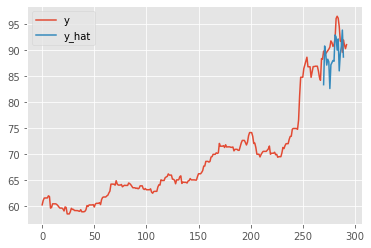

In [29]:
plot_id = 0
y_test_plot = X_plot.loc[X_plot['unique_id']==uniques[plot_id]]
plot_prediction(y_test_plot['y'], y_test_plot['y_hat'])

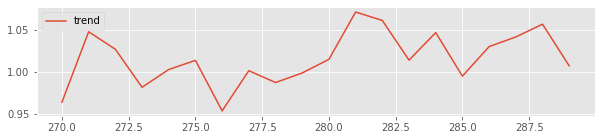

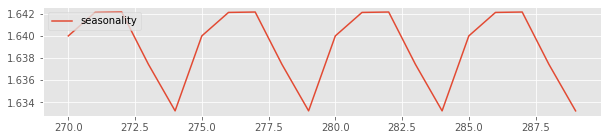

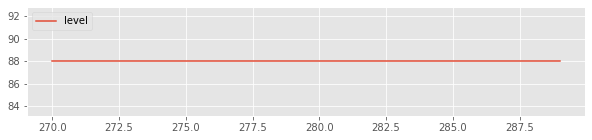

In [27]:
plot_decomposition(y_test_plot['trend'], y_test_plot['seasonalities'], y_test_plot['level'])